In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
tf.enable_eager_execution()

In [3]:
import tensorly as tl
from tensorly.decomposition import tucker 

Using numpy backend.


Why is this hard to think about!?

Want to find temporally abstract patterns between observations, actions and rewards.

In [4]:
env = gym.make('LunarLander-v2')

In [20]:
def play_episode(player, env, len_episode=100):
    obs = env.reset()
    trajectory = []
    old_obs = obs
    done = False
    
    # need fixed length trajectories
    for _ in range(len_episode):
        if not done:
            a = player(obs)
            obs, r, done, info = env.step(a)
            
        else:  # pad with zeros
            a = 0
            obs, r, done, info = (np.zeros(8), 0, done, None)
            
        trajectory.append(np.concatenate([np.array([a]), old_obs, np.array([r])]))
        old_obs = obs
    return np.vstack(trajectory)

In [21]:
len_episode = 50
n_actions = 4
n_possible_trajectories = n_actions**len_episode
print('Total possible trajectories = {}'.format(n_possible_trajectories))

Total possible trajectories = 1267650600228229401496703205376


In [22]:
trajectory = play_episode(lambda *args: env.action_space.sample(), env, len_episode)

In [23]:
# generate dataset using rnd policy
dataset = np.stack([play_episode(lambda *args: env.action_space.sample(), env, len_episode)
                      for _ in range(1000)], axis=0)

In [24]:
dataset.shape

(1000, 50, 10)

In [10]:
actions = dataset[:,1:,0]
actions = tf.constant(actions, dtype=tf.int32)
actions = tf.one_hot(actions, axis=-1, depth=4, off_value=0.0,on_value=1.0)
actions = actions.numpy()

In [26]:
# should use difference in observations/state?
# actions wouldnt necessarily correlate with absolute obs
# could have the same trajectory, with zero correlation bc different starting pts!?
obs = dataset[:,1:,1:-1] - dataset[:,:-1,1:-1]
print(actions.shape, obs.shape)

(1000, 49, 4) (1000, 49, 8)


In [34]:
R = np.sum(dataset[:,1:,-1], axis=-1)
R.shape

In [28]:
# what are we trying to do here?
# are there any patterns between the trajectory of actions and the observations?!?
corr = np.einsum('ijk,ijl->jkl', actions, obs)
corr /= dataset.shape[0]  # need to normalise!?

In [29]:
corr.shape

(49, 4, 8)

In [30]:
C, G = tucker(tensor=corr)

In [31]:
C.shape, [g.shape for g in G]

((49, 4, 8), [(49, 49), (4, 4), (8, 8)])

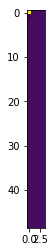

In [32]:
out = np.einsum('ijk,li,jm->ij', C, G[0], G[1])
# marginalise over g[-1] the observations
plt.imshow(out)

In [ ]:
n